In [1]:

from sentinelhub import SHConfig


INSTANCE_ID = ''  # In case you put instance ID into configuration file you can leave this unchanged
CLIENT_ID = ''
CLIENT_SECRET = ''
if INSTANCE_ID and CLIENT_ID and CLIENT_SECRET:
    config = SHConfig()
    config.instance_id = INSTANCE_ID
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET
else:
    config = None
    

In [2]:
config.save()


In [3]:
"""
%reload_ext autoreload
%autoreload 2
%matplotlib inline
"""

'\n%reload_ext autoreload\n%autoreload 2\n%matplotlib inline\n'

In [4]:
import datetime
import numpy as np

import matplotlib.pyplot as plt
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, SentinelHubRequest

In [5]:
from sentinelhub import DataSource

for source in DataSource.get_available_sources():
    print(source)

DataSource.SENTINEL2_L1C
DataSource.SENTINEL2_L2A
DataSource.SENTINEL1_IW
DataSource.SENTINEL1_EW
DataSource.SENTINEL1_EW_SH
DataSource.SENTINEL1_IW_ASC
DataSource.SENTINEL1_EW_ASC
DataSource.SENTINEL1_EW_SH_ASC
DataSource.SENTINEL1_IW_DES
DataSource.SENTINEL1_EW_DES
DataSource.SENTINEL1_EW_SH_DES
DataSource.DEM
DataSource.MODIS
DataSource.LANDSAT8


In [6]:

volcano_bbox = BBox(bbox=[(-2217485.0, 9228907.0), (-2150692.0, 9284045.0)], crs=CRS.POP_WEB)

ua_coords_wgs84 = [
    49.845775018245774, 
    29.073321247506765, 
    51.278667808079206, 
    31.986007792928522,
]
ua_bbox = BBox(ua_coords_wgs84, crs=CRS.WGS84)

evalscript = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"],
                units: "DN"
            }],
            output: {
                bands: 3,
                sampleType: "UINT16"
            }
        };
    }

    function updateOutputMetadata(scenes, inputMetadata, outputMetadata) {
        outputMetadata.userData = { "norm_factor":  inputMetadata.normalizationFactor }
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_source=DataSource.SENTINEL2_L2A,
            time_interval=('2017-08-21', '2017-08-22'),
            mosaicking_order='leastCC'
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),
        SentinelHubRequest.output_response('userdata', MimeType.JSON)
    ],
    bbox=ua_bbox,
    size=(512, 512),
    config=config
)


l2a_data = request.get_data()
#plot_image(l2a_data[0])


In [7]:
print(request.get_data())

[{'default.tif': array([[[2779, 2163, 1578],
        [2857, 2197, 1590],
        [2456, 1912, 1400],
        ...,
        [   0,    0,    0],
        [   0,    0,    0],
        [   0,    0,    0]],

       [[2442, 2130, 1635],
        [2425, 2070, 1593],
        [2260, 1833, 1342],
        ...,
        [   0,    0,    0],
        [   0,    0,    0],
        [   0,    0,    0]],

       [[2232, 1738, 1259],
        [1949, 1492, 1044],
        [1606, 1269,  899],
        ...,
        [   0,    0,    0],
        [   0,    0,    0],
        [   0,    0,    0]],

       ...,

       [[ 942, 1065, 1138],
        [ 961, 1088, 1169],
        [ 930, 1049, 1120],
        ...,
        [   0,    0,    0],
        [   0,    0,    0],
        [   0,    0,    0]],

       [[ 922, 1043, 1121],
        [ 964, 1092, 1163],
        [ 950, 1069, 1144],
        ...,
        [   0,    0,    0],
        [   0,    0,    0],
        [   0,    0,    0]],

       [[ 953, 1076, 1158],
        [ 915, 1036, 1112],

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


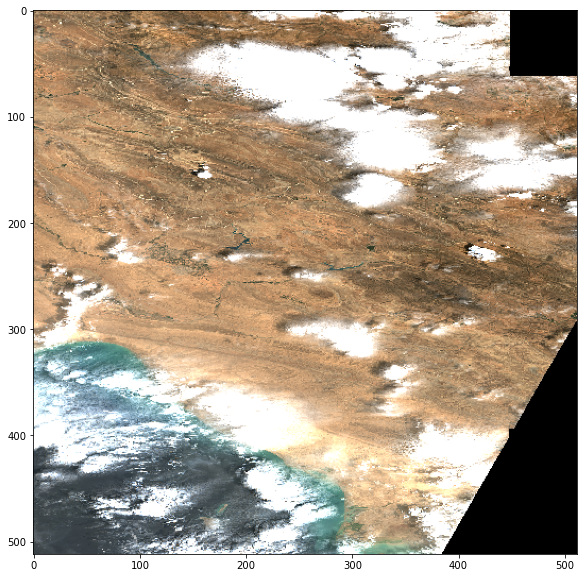

In [8]:
tar_img = l2a_data[0]['default.tif'].astype(np.float32)
norm_factor = l2a_data[0]['userdata.json']['norm_factor']
tar_img = tar_img * norm_factor
plt.figure(figsize=(10,10))
plt.imshow(tar_img * 2.5)